<a href="https://colab.research.google.com/github/poponzu/Research/blob/master/DAE%E8%BF%BD%E5%8A%A0%E7%94%A8_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [76]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [77]:
!pip install tensorflow==1.14.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [78]:
!pip install keras==2.3.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [79]:
import numpy as np
import tensorflow as tf
import random as rn
import numpy as np

import os

os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
rn.seed(12345)
# import tensorflow as tf
# print(tf.__version__)

session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1, inter_op_parallelism_threads=1
)

# session_conf = tf.compat.v1.ConfigProto(
#     intra_op_parallelism_threads=1, inter_op_parallelism_threads=1
# )

from tensorflow import keras 
from keras import backend as K

tf.set_random_seed(1234)
# tf.random.set_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from keras.layers import Input, Dense,LSTM,RepeatVector,GRU,Dropout,Reshape
from keras.layers import*
from keras.models import Model
from keras.models import Sequential
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
import matplotlib.pyplot as plt
from math import sqrt
import random
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


In [80]:
def parser(x):
	return datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[:,0][-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = []
	for x in X:
   		 new_row = new_row+[i for i in x]
            
	new_row.append(value) 
	new_row_2 = np.array(new_row)
	new_row_2 = new_row_2.reshape((1,new_row_2.shape[0]))
	inverted = scaler.inverse_transform(new_row_2)
	return inverted[0, -1]


def create_dataset(dataset,features, look_back=1):
	dataset = np.insert(dataset,[0]*look_back,0)    
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back)]
		dataX.append(a)
		dataY.append(dataset[i + look_back])
	dataY= np.array(dataY)        
	dataY = np.reshape(dataY,(dataY.shape[0],features))
	dataset = np.concatenate((dataX,dataY),axis=1)  
	return dataset



# convert series to supervised learning
def series_to_supervised(data,features, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	x = np.zeros(features, dtype=np.int)
	for i in range(n_in):
		data = np.insert(data,x,0)
	data = data.reshape(int(data.shape[0]/features),features) 
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(batch_size, X.shape[0], X.shape[1])
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]


# def read_data(): 

	
# 	window_size = 0
# 	features = 8


# 	series = read_csv('pollution.csv', header=0, index_col=0)	
# 	raw_values = series.values

# 	# integer encode wind direction
# 	encoder = LabelEncoder()
# 	raw_values[:,4] = encoder.fit_transform(raw_values[:,4])

# 	# transform data to be stationary
# 	diff = difference(raw_values, 1)


# 	dataset = diff.values
# 	dataset = create_dataset(dataset,features,window_size)


# 	return dataset,raw_values

In [81]:
space = {'seq_len':hp.choice('seq_len',[5,10,15,20,25,30]),
         'epochs_pre':hp.choice('epochs_pre',[i for i in range(50,1000)]),
         'epochs_finetune':hp.choice('epochs_finetune',[i for i in range(50,500)]),
         'units':hp.choice('units',[i for i in range(1,50)]),
         'dropout':hp.choice('dropout',[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]),
         'batch_size':hp.choice('batch_size',[73, 146, 219])}

In [82]:
params = {'seq_len': 10,
          'epochs_pre': 100,
          'epochs_finetune': 50,
          'units': 20,
          'dropout': 0.2,
          'batch_size': 73}

In [83]:
hidden_layers = [35,49,4]
batch_size = 219
dropout = 0.2
seq_len = 25
epochs_pre  = [625,115,933]
# デバッグ用
epochs_pre  = [1,1,1]
epochs_finetune = 197
epochs_finetune = 1
window_size = 0
features = 8

In [84]:
series = read_csv('/content/drive/MyDrive/Colab Notebooks/jimang/pollution.csv', header=0, index_col=0)
series.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138,-7,-5.0,1022.0,SE,6.25,2,0


In [85]:
series = read_csv('/content/drive/MyDrive/Colab Notebooks/jimang/pollution.csv', header=0, index_col=0)
raw_values = series.values

# integer encode wind direction
encoder = LabelEncoder()
raw_values[:,4] = encoder.fit_transform(raw_values[:,4])

# transform data to be stationary
diff = difference(raw_values, 1)


dataset = diff.values
dataset = create_dataset(dataset,features,window_size)

In [86]:
print(dataset)

[[19 1 0.0 ... 0.8900000000000001 0 0]
 [11 4 -1.0 ... 0.8899999999999997 0 0]
 [22 4 0.0 ... 1.7900000000000005 1 0]
 ...
 [0 0 0.0 ... 4.9199999999999875 0 0]
 [-2 0 -1.0 ... 4.02000000000001 0 0]
 [4 1 1.0 ... 3.1299999999999955 0 0]]


In [87]:
# frame as supervised learning
reframed = series_to_supervised(dataset,features, seq_len, 1)
drop = [i for  i in  range(seq_len*features+1,((seq_len+1)*features))]
reframed.drop(reframed.columns[drop], axis=1, inplace=True)
reframed = reframed.values

# split into train and test sets
train_size = 365*24*4
train, test = reframed[0:train_size], reframed[train_size:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# split into input and outputs
x_train,y_train = train_scaled[:,0:-1],train_scaled[:,-1]
x_test,y_test = test_scaled[:,0:-1],test_scaled[:,-1]

# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape(x_train.shape[0],seq_len,features)
x_test = x_test.reshape(x_test.shape[0],seq_len,features)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(35040, 25, 8) (35040,) (8759, 25, 8) (8759,)


# 論文にはPM2.5のデータセットはトレーニング用に30,660、検証用に4380、そしてテスト用に8760件に分けたとのこと。
# validationデータ追加

In [88]:
# frame as supervised learning
reframed = series_to_supervised(dataset,features, seq_len, 1)
drop = [i for  i in  range(seq_len*features+1,((seq_len+1)*features))]
reframed.drop(reframed.columns[drop], axis=1, inplace=True)
reframed = reframed.values

# split into train and test sets
train_size = 30660
val_size = 4380
test_size = 8760

train, val = reframed[0:train_size], reframed[train_size:train_size+val_size]
test = reframed[train_size+val_size:]

# transform the scale of the data
scaler, train_scaled, val_scaled = scale(train, val)
scaler, train_scaled, test_scaled = scale(train, test)

# split into input and outputs
x_train,y_train = train_scaled[:,0:-1],train_scaled[:,-1]
x_val, y_val = val_scaled[:,0:-1],val_scaled[:,-1]
x_test,y_test = test_scaled[:,0:-1],test_scaled[:,-1]

# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape(x_train.shape[0],seq_len,features)
x_val = x_val.reshape(x_val.shape[0],seq_len,features)
x_test = x_test.reshape(x_test.shape[0],seq_len,features)

print(x_train.shape, y_train.shape,x_val.shape, y_val.shape,x_test.shape, y_test.shape)

(30660, 25, 8) (30660,) (4380, 25, 8) (4380,) (8759, 25, 8) (8759,)


In [89]:
print('\nstart pretraining')
print('===============')

timesteps = x_train.shape[1]
input_dim = x_train.shape[2]
trained_encoder = []
x_train_temp = x_train


start pretraining


In [90]:
print('>> 1 LAYERS')
hidden = hidden_layers[0]
epochs = epochs_pre[0]


>> 1 LAYERS


In [91]:
import tensorflow as tf
print(tf.__version__)

1.14.0


In [92]:
inputs = Input(batch_shape=(5, timesteps, x_train_temp.shape[2]))
encoded1 = LSTM(
    hidden, # 35
    batch_input_shape=(5, timesteps, x_train_temp.shape[2]),
    stateful=False)(inputs)
encoded2 = LSTM(
    hidden, # 35
    batch_input_shape=(5, timesteps, x_train_temp.shape[2]),
    stateful=True)(inputs)

In [93]:
ae1 = Model(inputs, encoded1)
ae2 = Model(inputs, encoded2)

In [94]:
ae1.predict(x_train_temp[0:5])

array([[ 0.25834736,  0.04556986, -0.16819178, -0.15076211, -0.04636417,
        -0.05681205,  0.04462088, -0.12166876,  0.23039207,  0.11585266,
        -0.04802071,  0.28240436, -0.19591643, -0.24320899, -0.13537261,
        -0.0928885 ,  0.20452426,  0.10199052,  0.11421486,  0.3057708 ,
         0.04566206, -0.21825531,  0.10423727,  0.11251348, -0.03263811,
        -0.02519069,  0.03084422,  0.07526544,  0.10128684, -0.24836975,
        -0.00649066,  0.14892788, -0.29681593, -0.18718567, -0.12126818],
       [ 0.260427  ,  0.04472234, -0.17095211, -0.15225191, -0.04752081,
        -0.05633098,  0.04562952, -0.12216279,  0.23123561,  0.11827005,
        -0.04858857,  0.28368732, -0.19589649, -0.24551916, -0.1360664 ,
        -0.09447763,  0.20154485,  0.10296758,  0.11556982,  0.30577815,
         0.04542454, -0.22110377,  0.10293055,  0.11258145, -0.03135569,
        -0.02602114,  0.02787184,  0.07502163,  0.09935708, -0.2486042 ,
        -0.00801667,  0.1480727 , -0.29834995, -0.

In [95]:
ae2.predict(x_train_temp[0:5])

array([[ 7.36578330e-02,  9.08287615e-02, -1.19508483e-01,
         3.31405252e-02,  2.99641669e-01, -7.85488486e-02,
        -7.44195729e-02,  3.31544310e-01, -2.65809774e-01,
        -1.24132566e-01,  1.31265432e-01,  9.61057991e-02,
        -2.19323069e-01, -1.27486184e-01,  1.90028036e-03,
        -5.71898185e-02,  9.60161686e-02, -2.21904576e-01,
        -1.96538284e-01,  1.22552954e-01,  1.51350349e-01,
         5.98589778e-02,  2.71965470e-02, -2.42074907e-01,
         9.21564922e-02,  6.73173815e-02,  1.71085298e-01,
         1.83979422e-02, -2.41310578e-02, -5.21199107e-02,
        -5.43504246e-02, -2.66858697e-01,  6.42151386e-02,
        -1.51203005e-02, -1.70809731e-01],
       [ 7.18078241e-02,  9.07338411e-02, -1.21220775e-01,
         3.19269300e-02,  2.99623638e-01, -7.79555440e-02,
        -7.51759782e-02,  3.33913535e-01, -2.67163098e-01,
        -1.21644981e-01,  1.30789563e-01,  9.51659456e-02,
        -2.18886554e-01, -1.26007959e-01,  6.77164135e-05,
        -5.82

In [96]:
print(f'pretrain Autoencoder: {0} ----> Encoder: {hidden} ----> Epochs: {epochs}')
print(x_train_temp.shape)
print('=============================================================')

inputs = Input(
    # (219, 25, 8)
    batch_shape=(batch_size, timesteps, x_train_temp.shape[2]))
encoded = LSTM(
    hidden, # 35
    batch_input_shape=(batch_size, timesteps, x_train_temp.shape[2]),
    stateful = False)(inputs)
decoded = RepeatVector(timesteps)(encoded) 
decoded = LSTM(input_dim, stateful=False, return_sequences=True)(decoded)

AE = Model(inputs, decoded)

encoder = Model(inputs,encoded)

AE.compile(loss='mean_squared_error', optimizer='Adam')

encoder.compile(loss='mean_squared_error', optimizer='Adam')

AE.summary()

pretrain Autoencoder: 0 ----> Encoder: 35 ----> Epochs: 1
(30660, 25, 8)
Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (219, 25, 8)              0         
_________________________________________________________________
lstm_12 (LSTM)               (219, 35)                 6160      
_________________________________________________________________
repeat_vector_9 (RepeatVecto (219, 25, 35)             0         
_________________________________________________________________
lstm_13 (LSTM)               (219, 25, 8)              1408      
Total params: 7,568
Trainable params: 7,568
Non-trainable params: 0
_________________________________________________________________


In [97]:
AE.fit(
    x_train_temp, 
    x_train,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    verbose=1
)

Epoch 1/1
30660/30660 [==============================] - 6s 185us/step - loss: 0.0760


In [98]:
# store trained encoder and its weights
trained_encoder.append(
    (AE.layers[1], AE.layers[1].get_weights())
)

# update training data
x_train_temp = encoder.predict(x_train_temp, batch_size=batch_size)

In [99]:
x_train_temp.shape

(30660, 35)

In [100]:
# reshape encoded input to 3D
inputs = Input(shape = (x_train_temp.shape[1],)) 
reshape = RepeatVector(timesteps)(inputs)
Repeat = Model(inputs,reshape)

x_train_temp = Repeat.predict(x_train_temp, batch_size=batch_size)

In [101]:
x_train_temp.shape

(30660, 25, 35)

In [102]:
print('>> 2 LAYERS')
hidden = hidden_layers[1]
epochs = epochs_pre[1]

>> 2 LAYERS


In [103]:
print(f'pretrain Autoencoder: {1} ----> Encoder: {hidden} ----> Epochs: {epochs}')
print(x_train_temp.shape)
print('=============================================================')

inputs = Input(
    # (219, 25, 35)
    batch_shape=(batch_size, timesteps, x_train_temp.shape[2]))
encoded = LSTM(
    hidden, # 49
    batch_input_shape=(batch_size, timesteps, x_train_temp.shape[2]),
    stateful = False)(inputs)
decoded = RepeatVector(timesteps)(encoded) 
decoded = LSTM(input_dim, stateful=False, return_sequences=True)(decoded)

AE = Model(inputs, decoded)

encoder = Model(inputs,encoded)

AE.compile(loss='mean_squared_error', optimizer='Adam')

encoder.compile(loss='mean_squared_error', optimizer='Adam')

AE.summary()

pretrain Autoencoder: 1 ----> Encoder: 49 ----> Epochs: 1
(30660, 25, 35)
Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (219, 25, 35)             0         
_________________________________________________________________
lstm_14 (LSTM)               (219, 49)                 16660     
_________________________________________________________________
repeat_vector_11 (RepeatVect (219, 25, 49)             0         
_________________________________________________________________
lstm_15 (LSTM)               (219, 25, 8)              1856      
Total params: 18,516
Trainable params: 18,516
Non-trainable params: 0
_________________________________________________________________


In [104]:
AE.fit(
    x_train_temp, 
    x_train,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    verbose=1
)

Epoch 1/1
30660/30660 [==============================] - 14s 447us/step - loss: 0.0455


In [105]:
# store trained encoder and its weights
trained_encoder.append(
    (AE.layers[1], AE.layers[1].get_weights())
)

# update training data
x_train_temp = encoder.predict(x_train_temp, batch_size=batch_size)

In [106]:
x_train_temp.shape

(30660, 49)

In [107]:
# reshape encoded input to 3D
inputs = Input(shape = (x_train_temp.shape[1],)) 
reshape = RepeatVector(timesteps)(inputs)
Repeat = Model(inputs,reshape)

x_train_temp = Repeat.predict(x_train_temp, batch_size=batch_size)

In [108]:
x_train_temp.shape

(30660, 25, 49)

In [109]:
print('>> 3 LAYERS')
hidden = hidden_layers[2]
epochs = epochs_pre[2]

>> 3 LAYERS


In [110]:
print(f'pretrain Autoencoder: {2} ----> Encoder: {hidden} ----> Epochs: {epochs}')
print(x_train_temp.shape)
print('=============================================================')

inputs = Input(
    # (219, 25, 49)
    batch_shape=(batch_size, timesteps, x_train_temp.shape[2]))
encoded = LSTM(
    hidden, # 4
    batch_input_shape=(batch_size, timesteps, x_train_temp.shape[2]),
    stateful = False)(inputs)
decoded = RepeatVector(timesteps)(encoded) 
decoded = LSTM(input_dim, stateful=False, return_sequences=True)(decoded)

AE = Model(inputs, decoded)

encoder = Model(inputs,encoded)

AE.compile(loss='mean_squared_error', optimizer='Adam')

encoder.compile(loss='mean_squared_error', optimizer='Adam')

AE.summary()

pretrain Autoencoder: 2 ----> Encoder: 4 ----> Epochs: 1
(30660, 25, 49)
Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (219, 25, 49)             0         
_________________________________________________________________
lstm_16 (LSTM)               (219, 4)                  864       
_________________________________________________________________
repeat_vector_13 (RepeatVect (219, 25, 4)              0         
_________________________________________________________________
lstm_17 (LSTM)               (219, 25, 8)              416       
Total params: 1,280
Trainable params: 1,280
Non-trainable params: 0
_________________________________________________________________


In [111]:
AE.fit(
    x_train_temp, 
    x_train,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    verbose=1
)

Epoch 1/1
30660/30660 [==============================] - 5s 158us/step - loss: 0.1643


In [112]:
# store trained encoder and its weights
trained_encoder.append(
    (AE.layers[1], AE.layers[1].get_weights())
)

# update training data
x_train_temp = encoder.predict(x_train_temp, batch_size=batch_size)

In [113]:
x_train_temp.shape

(30660, 4)

In [114]:
# reshape encoded input to 3D
inputs = Input(shape = (x_train_temp.shape[1],)) 
reshape = RepeatVector(timesteps)(inputs)
Repeat = Model(inputs,reshape)

x_train_temp = Repeat.predict(x_train_temp, batch_size=batch_size)

In [115]:
x_train_temp.shape

(30660, 25, 4)

In [125]:
# Fine-turning
print('\nFine-turning')
print('============')

l = len(trained_encoder)
#build finetuning model
model = Sequential()
for i,encod in enumerate(trained_encoder):
    model.add(encod[0])
    model.layers[-1].set_weights(encod[1])
    model.add(Dropout(dropout))
    if(i+1 != l): model.add(RepeatVector(timesteps))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='Adam')

history = model.fit(
    x_train, 
    y_train, 
    validation_data=(x_val, y_val),
    epochs=epochs_finetune, 
    batch_size=batch_size, 
    verbose=1,
    shuffle=True
)


Fine-turning
Train on 30660 samples, validate on 4380 samples
Epoch 1/1
30660/30660 [==============================] - 14s 451us/step - loss: 0.0225 - val_loss: 6.8033e-04


# Lossの値の可視化

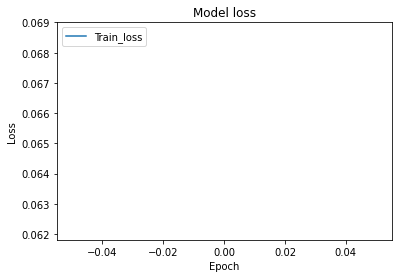

In [117]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train_loss', 'Test'], loc='upper left')
plt.show()

In [118]:
# save trained model
model.save('3layer_25.h5')

# redefine the model in order to test with one sample at a time (batch_size = 1)
new_model = Sequential()
new_model.add(
    LSTM(
        hidden_layers[0],
        batch_input_shape=(1, timesteps, input_dim),
        stateful=False)
)
for layer in model.layers[1:]:
    new_model.add(layer)

# copy weights
old_weights = model.get_weights()
new_model.set_weights(old_weights)

In [119]:
def smape(A, F):
    return 100/len(A) * np.sum(np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [120]:
import tqdm

# forecast the entire training dataset to build up state for forecasting
print('Forecasting Training Data')   
predictions_train = list()
for i in tqdm.tqdm(range(len(y_train))):
    # make one-step forecast
    X = x_train[i]
    y= y_train[i]
    yhat = forecast_lstm(new_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(raw_values)-i)
    # store forecast
    predictions_train.append(yhat)
    expected = raw_values[:,0][ i+1 ] 
    #print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

# report performance
rmse_train = sqrt(mean_squared_error(raw_values[:,0][1:len(train_scaled)+1], predictions_train))
print('Train RMSE: %.5f' % rmse_train)
# #report performance using RMSPE
# RMSPE_train = RMSPE(raw_values[:,0][1:len(train_scaled)+1],predictions_train)
# print('Train RMSPE: %.5f' % RMSPE_train)
MAE_train = mean_absolute_error(raw_values[:,0][1:len(train_scaled)+1], predictions_train)
print('Train MAE: %.5f' % MAE_train)
# MAPE_train = MAPE(raw_values[:,0][1:len(train_scaled)+1], predictions_train)
# print('Train MAPE: %.5f' % MAPE_train)
SMAPE_train = smape(raw_values[:,0][1:len(train_scaled)+1], predictions_train)
print('Train SMAPE: %.5f' % SMAPE_train)

Forecasting Training Data
Train RMSE: 34.24789
Train MAE: 23.96830
Train SMAPE: 37.31344


In [121]:
SMAPE_train = smape(raw_values[:,0][1:len(train_scaled)+1], predictions_train)
print('Train SMAPE: %.5f' % SMAPE_train)

Train SMAPE: 37.31344


In [122]:
# forecast the test data
print('Forecasting Testing Data')
predictions_test = list()
for i in range(len(y_test)):
    # make one-step forecast
    X = x_test[i]
    y= y_test[i]
    yhat = forecast_lstm(new_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions_test.append(yhat)
    expected = raw_values[:,0][len(train) + i + 1]
    #print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

# report performance using RMSE
rmse_test = sqrt(mean_squared_error(raw_values[:,0][-len(test_scaled):], predictions_test))
print('Test RMSE: %.5f' % rmse_test)
#report performance using RMSPE
# RMSPE_test = RMSPE(raw_values[:,0][-len(test_scaled):], predictions_test)
# print('Test RMSPE: %.5f' % RMSPE_test)
MAE_test = mean_absolute_error(raw_values[:,0][-len(test_scaled):], predictions_test)
print('Test MAE: %.5f' % MAE_test)
# MAPE_test = MAPE(raw_values[:,0][-len(test_scaled):], predictions_test)
# print('Test MAPE: %.5f' % MAPE_test)
SMAPE_test = smape(raw_values[:,0][-len(test_scaled):], predictions_test)
print('Test SMAPE: %.5f' % SMAPE_test)

Forecasting Testing Data
Test RMSE: 30.53288
Test MAE: 22.90594
Test SMAPE: 34.73650


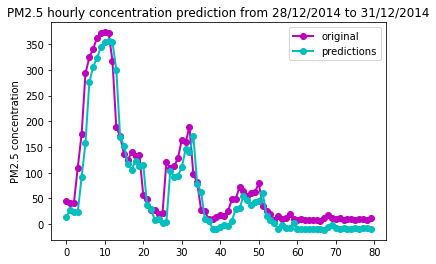

In [123]:
# line plot of observed vs predicted
fig, ax = plt.subplots(1)
ax.plot(raw_values[:,0][-80:],'mo-', label='original',linewidth = 2 )
ax.plot(predictions_test[-80:] ,'co-', label='predictions',linewidth = 2)
#ax.axvline(x=len(train_scaled)+1,color='k', linestyle='--')
ax.legend(loc='upper right')
ax.set_title('PM2.5 hourly concentration prediction from 28/12/2014 to 31/12/2014')
ax.set_ylabel('PM2.5 concentration')
plt.show()